In [1]:
import sys
sys.path.insert(1, '/home/richard/nfmc_jax/')
import nfmc_jax
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from sklearn.neighbors import KernelDensity
import jax
import jax.numpy as jnp
import chaospy

# 1d Gaussian likelihood and prior test for nfmc_jax

In [2]:
def log_like(x, mu=0, sigma=1):
    return -0.5 * jnp.log(2 * np.pi * sigma ** 2) - 0.5 * (x - mu) ** 2 / (2 * sigma ** 2)

def log_prior(x):
    return -0.5 * jnp.log(2 * np.pi * 5.0 ** 2) - 0.5 * (x) ** 2 / (2 * 5.0 ** 2)

key = jax.random.PRNGKey(100)
prior_samples = jax.random.multivariate_normal(key, mean=jnp.array([0.0]), 
                                               cov=jnp.array([[5.0]]), shape=(20,))
prior_samples.shape[1]

1

In [3]:
trace = nfmc_jax.sample_nfo(log_like, log_prior, prior_samples, log_like_args=(0, 1), log_prior_args=(),
                            vmap=True, parallel_backend=None, n0=20, iteration=5, aN=100, bN=10, num_local=2,
                            nfmc_samples=10, nf_iter=10, k_trunc=0.5, ess_tol=1.0)

stage:  0
theta0:  [[ 1.907436  ]
 [ 1.0259556 ]
 [ 0.80545896]
 [-1.5762843 ]
 [-0.95625234]
 [ 0.8192929 ]
 [-1.2089099 ]
 [ 0.69928545]
 [ 4.3300214 ]
 [-2.5153143 ]
 [-0.29137895]
 [ 2.1552372 ]
 [-4.185222  ]
 [-2.634192  ]
 [-0.97664833]
 [-1.0182428 ]
 [-2.9053328 ]
 [-0.7228617 ]
 [-2.1855989 ]
 [-0.18935743]]
Initialization logZ: -1.487, ESS/N: 0.747, logZ_pq: -1.417 log mean loss: -9.260
Stage: 1
No weights in the fit


/home/richard/nfmc_jax/nfmc_jax/nfo/nfo.py:308: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448222085/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  self.nf_model = GIS(torch.from_numpy(np.asarray(self.samples)),
/home/richard/nfmc_jax/nfmc_jax/sinf/SINF.py:492: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /opt/conda/co

beta =  1
weighting fit
Removing 4 samples with the lowest logp values.
Left with 28 samples after culling.
Importance weight length after culling: 28.
Initialization logZ: -2.945, ESS/N: 0.786, logZ_pq: -2.703 log mean loss: -10.002
Finished annealing steps.
Perform NFMC fits using samples collected up to beta=1.
No weights in the fit
weighting fit
Removing 4 samples with the lowest logp values.
Left with 38 samples after culling.
Importance weight length after culling: 38.
Initialization logZ: -2.238, ESS/N: 0.419, logZ_pq: -2.612 log mean loss: -10.420
No weights in the fit
weighting fit
Additional NFMC fits have decreased ESS for the given q - stopping.


dict_keys(['q0', 'q1', 'q1_w_samples', 'q_nfmc1', 'q_nfmc1_w_samples'])
dict_keys(['q0', 'q0_pq', 'q1', 'q1_pq', 'q1_IW2', 'q1_IW3', 'q1_pq_uw', 'q1_pq_w', 'q_nfmc1', 'q_nfmc1_pq', 'q_nfmc1_IW2', 'q_nfmc1_IW3', 'q_nfmc1_pq_uw', 'q_nfmc1_pq_w'])


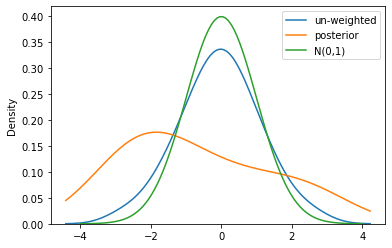

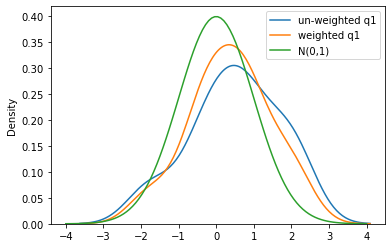

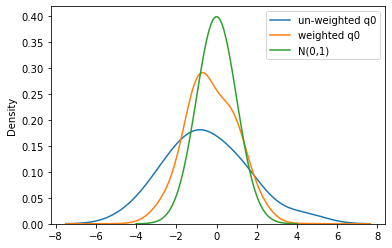

In [4]:
posterior = trace['posterior']

betas = trace['betas']

x = np.asarray(posterior).squeeze()
w = trace['posterior_weights'][0]

q_samples = trace['q_samples'][0]
q_weights = trace['importance_weights'][0]
print(q_samples.keys())
print(q_weights.keys())

def gauss(z):
    return np.exp(-z ** 2 / 2) / np.sqrt(2 * np.pi)

z = np.linspace(-4, 4, 100)
plt.figure()
sns.kdeplot(x, label='un-weighted')
sns.kdeplot(x, weights=w, label='posterior')
plt.plot(z, gauss(z), label='N(0,1)')
plt.legend(loc='upper right')

plt.figure()
sns.kdeplot(q_samples['q1'].squeeze(), label='un-weighted q1')
sns.kdeplot(q_samples['q1'].squeeze(), weights=np.clip(q_weights['q1'], a_min=0, a_max=None), 
            label='weighted q1')
plt.plot(z, gauss(z), label='N(0,1)')
plt.legend(loc='upper right')

plt.figure()
sns.kdeplot(q_samples['q0'].squeeze(), label='un-weighted q0')
sns.kdeplot(q_samples['q0'].squeeze(), weights=np.clip(q_weights['q0'], a_min=0, a_max=None), 
            label='weighted q0')
plt.plot(z, gauss(z), label='N(0,1)')
plt.legend(loc='upper right')

In [3]:
trace = nfmc_jax.sample_nfo(log_like, log_prior, prior_samples, log_like_args=(0, 1), log_prior_args=(),
                            vmap=True, parallel_backend=None, n0=20, iteration=5, aN=100, bN=10, num_local=2,
                            nfmc_samples=10, nf_iter=10, k_trunc=0.5, ess_tol=1.0)

stage:  0
theta0:  [[ 1.907436  ]
 [ 1.0259556 ]
 [ 0.80545896]
 [-1.5762843 ]
 [-0.95625234]
 [ 0.8192929 ]
 [-1.2089099 ]
 [ 0.69928545]
 [ 4.3300214 ]
 [-2.5153143 ]
 [-0.29137895]
 [ 2.1552372 ]
 [-4.185222  ]
 [-2.634192  ]
 [-0.97664833]
 [-1.0182428 ]
 [-2.9053328 ]
 [-0.7228617 ]
 [-2.1855989 ]
 [-0.18935743]]
Initialization logZ: -1.487, ESS/N: 0.747, logZ_pq: -1.417 log mean loss: -9.260
Stage: 1
No weights in the fit


/home/richard/nfmc_jax/nfmc_jax/nfo/nfo.py:308: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448222085/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  self.nf_model = GIS(torch.from_numpy(np.asarray(self.samples)),
/home/richard/nfmc_jax/nfmc_jax/sinf/SINF.py:492: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /opt/conda/co

beta =  1
weighting fit
Removing 4 samples with the lowest logp values.
Left with 28 samples after culling.
Importance weight length after culling: 28.
Initialization logZ: -2.946, ESS/N: 0.786, logZ_pq: -2.732 log mean loss: -10.002
Finished annealing steps.
Perform NFMC fits using samples collected up to beta=1.
No weights in the fit
weighting fit
Removing 4 samples with the lowest logp values.
Left with 38 samples after culling.
Importance weight length after culling: 38.
Initialization logZ: -2.382, ESS/N: 0.480, logZ_pq: -2.636 log mean loss: -10.302
No weights in the fit
weighting fit
Removing 4 samples with the lowest logp values.
Left with 48 samples after culling.
Importance weight length after culling: 48.
Initialization logZ: -2.452, ESS/N: 0.640, logZ_pq: -2.595 log mean loss: -10.464
No weights in the fit
weighting fit
Removing 4 samples with the lowest logp values.
Left with 58 samples after culling.
Importance weight length after culling: 58.
Initialization logZ: -2.018,

dict_keys(['q0', 'q1', 'q1_w_samples', 'q_nfmc1', 'q_nfmc1_w_samples', 'q_nfmc2', 'q_nfmc2_w_samples', 'q_nfmc3', 'q_nfmc3_w_samples', 'q_nfmc4', 'q_nfmc4_w_samples', 'q_nfmc5', 'q_nfmc5_w_samples', 'q_nfmc6', 'q_nfmc6_w_samples', 'q_nfmc7', 'q_nfmc7_w_samples', 'q_nfmc8', 'q_nfmc8_w_samples', 'q_nfmc9', 'q_nfmc9_w_samples', 'q_nfmc10', 'q_nfmc10_w_samples'])
dict_keys(['q0', 'q0_pq', 'q1', 'q1_pq', 'q1_IW2', 'q1_IW3', 'q1_pq_uw', 'q1_pq_w', 'q_nfmc1', 'q_nfmc1_pq', 'q_nfmc1_IW2', 'q_nfmc1_IW3', 'q_nfmc1_pq_uw', 'q_nfmc1_pq_w', 'q_nfmc2', 'q_nfmc2_pq', 'q_nfmc2_IW2', 'q_nfmc2_IW3', 'q_nfmc2_pq_uw', 'q_nfmc2_pq_w', 'q_nfmc3', 'q_nfmc3_pq', 'q_nfmc3_IW2', 'q_nfmc3_IW3', 'q_nfmc3_pq_uw', 'q_nfmc3_pq_w', 'q_nfmc4', 'q_nfmc4_pq', 'q_nfmc4_IW2', 'q_nfmc4_IW3', 'q_nfmc4_pq_uw', 'q_nfmc4_pq_w', 'q_nfmc5', 'q_nfmc5_pq', 'q_nfmc5_IW2', 'q_nfmc5_IW3', 'q_nfmc5_pq_uw', 'q_nfmc5_pq_w', 'q_nfmc6', 'q_nfmc6_pq', 'q_nfmc6_IW2', 'q_nfmc6_IW3', 'q_nfmc6_pq_uw', 'q_nfmc6_pq_w', 'q_nfmc7', 'q_nfmc7_pq', '

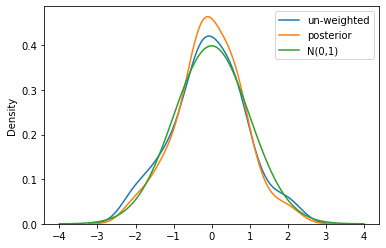

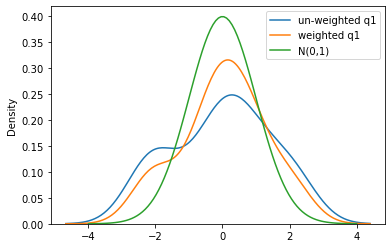

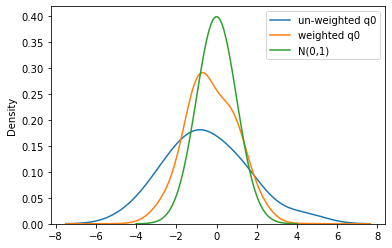

In [4]:
posterior = trace['posterior']

betas = trace['betas']

x = np.asarray(posterior).squeeze()
w = trace['posterior_weights'][0]

q_samples = trace['q_samples'][0]
q_weights = trace['importance_weights'][0]
print(q_samples.keys())
print(q_weights.keys())

def gauss(z):
    return np.exp(-z ** 2 / 2) / np.sqrt(2 * np.pi)

z = np.linspace(-4, 4, 100)
plt.figure()
sns.kdeplot(x, label='un-weighted')
sns.kdeplot(x, weights=w, label='posterior')
plt.plot(z, gauss(z), label='N(0,1)')
plt.legend(loc='upper right')

plt.figure()
sns.kdeplot(q_samples['q1'].squeeze(), label='un-weighted q1')
sns.kdeplot(q_samples['q1'].squeeze(), weights=np.clip(q_weights['q1'], a_min=0, a_max=None), 
            label='weighted q1')
plt.plot(z, gauss(z), label='N(0,1)')
plt.legend(loc='upper right')

plt.figure()
sns.kdeplot(q_samples['q0'].squeeze(), label='un-weighted q0')
sns.kdeplot(q_samples['q0'].squeeze(), weights=np.clip(q_weights['q0'], a_min=0, a_max=None), 
            label='weighted q0')
plt.plot(z, gauss(z), label='N(0,1)')
plt.legend(loc='upper right')

# Prior samples sanity check ...

In [3]:
n=1
n_iter=1 #sinf iterations 
n_prior = 10#number of sobol points
n_samples = n_prior #not used explicitly
n0=n_prior
N=n_samples
#get sobol sequence for initial samples
low,high=-1.0,1.0
dist1d = chaospy.Iid(chaospy.Uniform(lower=low,upper=high),n)
init_prior=dist1d
init_prior = np.atleast_2d(dist1d.sample(n_prior,rule='sobol')).T
# init_prior=None
transform=None#'ahh'#'ahh' #turn off pymc3 transform 
if(transform is not None):
    trname='t'
    #logit( (x-a) / (b-a) )
    init_prior = None#inv_logit(init_prior,low,high)#logit((init_prior-low) /(high-low))
else:
    trname='nt'
knots=None#100 #default None
bw=0.5#None#1.#None#0.5#1. #default 2.0
redraw=False #don't redraw samples at every iteration, my local change
layers=2
ktrunc=np.inf #currently SKIPPING
bw_use_pq=True #whether to use pq loss in determining bw
t_ess=0.5
g_AF=1
aN=int(2*N)#10
bN=1#2#int(N/2)
beta_max=1.0

In [5]:
print(np.shape(init_prior))

(10, 1)
